# ***AccessViz Mapper - KUVA henkilökunnalle saavutettavuus työkalu***
Työkalulla pystyy analysoimaan saavutettavuuden matka-ajat erillaisten kuljetustapojen näkökulmilta.
- Hae LIPAS tai Palvelukartta tiedoston 
- Lataa YKR ruudut valitetusta palvelusta; palauttaa dataframein
- Valitse kuljetustapa ja visualisoi karttanäkymän/lataa shapefile
- Lisää väestö luvut ja visualisoi karttanäkymän/lataa shapefile
- Vertaile kaksi kuljetustapaa ja visualisoi karttanäkymän/lataa shapefile


***Follow the next steps and discover the Accessibility at Helsinki Region***

23/7/21

## NEXT STEPS:
	
1. Need to set up save as shp or gpkg buttons for grouped files, aka one shp or gpkg
2. Is there a way to automize the naming process for the maps? So that different datasets can use the same function? x
    - Check Mariasofia's code for this! x
3. Add option for palvelukartta and user input for the hakusana x
 4. Find out which functions necessary for creating and saving visualizations !! x
 5. Change first shapefile save to only return a dataframe in the code - less confusion for usersx
    - with chosen transport mode only choose necessary columns to make visualizations simpler in qgisx
    ROADBLOCK: How can we save the dataframe of all merged txt files? x
5. Clean up unneccessary cells and see if you can run all of them 
6. Should there still be a possibility to create maps for individual service points? 
(Maybe focus on the groups for now and see if you have time to put aside interactions for individual points somewhere else?)


## ***1. Palvelun Valitseminen: Lipas tai Palvelukartta***
________________________
Valitse listasta haluaamasi palvelukohde/kohteet

In [1]:
import folium
from pyproj import CRS
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import requests
import geojson
import shapely
from shapely.geometry import Point

In [2]:
# -----------------------------------------------------------------------------
#                                   FUNCTIONS
# -----------------------------------------------------------------------------

# define a global variable that can be used throughout many functions
table = gpd.GeoDataFrame()

def lipas_button_clicked(b):
    '''
    Def used to select and fetch dataframe from lipas 
    ------------------------------------------------------------
    PARAMETERS
    - b <button default>

    RETURNS
    - Automatic append of selected YKR IDs <list element> (global variable)
    - Message in display
    '''
    # Retrieve typecode of lipas data 
    code = select_lipas.value
    
    # Run function for LIPAS data
    lipas = GetLipasData(code)
    # Define the boundaries of Helsinki
    ykr = GetCroppedYKR()

    # join the dataframes in order to find which ykr grid each point belongs to 
    global table
    table = gpd.sjoin(lipas, ykr, how="inner", op="within")

    # store the ids from the function
    ids = ykr_ids(table)


def ykr_ids(table):
    '''
    Selects the ykr ids of the desired service points
    '''
    # create a list of the unique ykr ids that belong to each service point
    ykr_list = table['YKR_ID'].unique().tolist()

    # loop through that list and add each one to the global blank list of grid_ids
    for i in ykr_list:
        if i in ykr_list not in grid_ids:
            grid_ids.append(i)
            
    # Report the selected IDs to the user
    with out:
        return print('Selected YKR IDs: {}'.format(grid_ids))


def palvelu_button_clicked(c):

    '''
    Function used to define and fetch data from palvelukartta HEL
    '''
    # store the value of the keyword for search
    sana = str(hakusana_palv.value)
    # get the YKR grid for Helsinki
    ykr = GetCroppedYKR()
    # store the service points form the function
    palvelu_pisteet = GetPalvelukarttaData(sana, buffer=1000)

    # join the dataframes in order to find which ykr grid each point belongs to 
    global table
    table = gpd.sjoin(palvelu_pisteet, ykr, how="inner", op="within")

    # store the ids from the function
    ids = ykr_ids(table)


def on_button_clear(d):
    '''
    Def used to clear selected YKR IDs
    -----------------------------------
    PARAMETERS
    -c <default button>

    RETURNS
    - automatic empty list (global variable)
    - Message in display
    '''

    # clear global variable of selected YKR IDs
    grid_ids.clear()

    with out:
        clear_output()
        return print('Valinta tyhjennetty')

In [3]:
# --------------------------------------------------------------------------------------
# SETTING - READING THE YKR GRID DATA FOR TRAVEL TIMES IN HELSINKI REGION
# --------------------------------------------------------------------------------------

# home folder
home_folder = os.getcwd()
path_parent = os.path.dirname(home_folder)
os.chdir(path_parent) 

# local downloads folder
local_folder_default = os.path.join(path_parent, 'accessviz-mapper/downloads')
if not os.path.exists(local_folder_default):
    os.makedirs(local_folder_default)

def GetCroppedYKR(city='Helsinki'):
    """ Rajaa ykr-ruudukosta valitun kaupungin mukaisen osan. Oletuksena rajauksessa Helsinki. 
     HUOM! (MetropAccess_YKR_grid_EurefFIN.shp) on löydyttävä data-kansioista """ 
    
    # Set filepath  and read YKR grid
    grid_path = os.path.join(path_parent,'accessviz-mapper/data/MetropAccess_YKR_grid_EurefFIN.shp')
    ykr_grid = gpd.read_file(grid_path)
    
    # Aseta aineiston koordinaattijärjestelmä
    ykr_grid.crs = CRS.from_epsg(3067)
    
    # Erota ruudukosta kaupungin alue
    
    # Hae wfs rajapinnalta pk-seudun kuntarajat
    url = 'https://kartta.hel.fi/ws/geoserver/avoindata/wfs'
    r = requests.get(url, params = dict(service='WFS', version='2.0.0', request= 'GetFeature', 
    typeName='Seutukartta_aluejako_kuntarajat', outputFormat='json'))

    rajat = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

    # Määrittele koordinaattijärjestelmä (EPSG:3879) ja uudelleenprojisoi (EPSG: 3067)
    rajat.crs = CRS.from_epsg(3879)
    rajat = rajat.to_crs(CRS.from_epsg(3067))

    # valitse kuntarajat funktion parametrin mukaan (oletus Helsinki) 
    rajattu = rajat[rajat['nimi']==city]

    # rajaa ruudukosta Helsingin alue
    ykr = gpd.overlay(ykr_grid, rajattu, how='intersection') 

    # valitse ruudukosta oleelliset kolumnit ja poista loput
    grid = ykr[['YKR_ID', 'geometry']]


    return grid

In [4]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import jslink
from __future__ import print_function
from ipywidgets import Box, HTML, Layout, VBox, Label
from ipywidgets import TwoByTwoLayout, AppLayout

In [5]:
# List of possibilites to choose from for the LIPAS dropdown widget
lipas_options = [('Liikuntapuisto', '1110'), ('Lähiliikuntapaikka', '1120'), ('Ulkokuntoilupaikka', '1130'), ('Yleisurheilun harjoitusalue', '1210'), ('Kuntosali', '2120'), ('Liikuntahalli', '2210')]


# Function to fetch lipas data based on the chosen typecode
def GetLipasData(typecode):

    '''
    Hakee Lipas taulukon Lipaksen APIsta ja talentuu geodataframeina

    Argumentit: tyyppikoodi minkä käyttäjä valitsee interaktiivisesta widgets painikkeesta 
    '''

    # define an empty dataframe
    lipas = pd.DataFrame()

    # Fetch the LIPAS data from the Lipas API
    r = requests.get("""http://lipas.cc.jyu.fi/api/sports-places?fields=type.name&fields=location.sportsPlaces&fields=location.geometries&fields=name&fields=type.typeCode&fields=location.locationId&fields=location.city.name&fields=location.postalCode&fields=location.address&typeCodes=""" + typecode + """&cityCodes=91""").json()

    # Using json_normalize flatten the multi level JSON retrieved from the API into a dataframe
    df = pd.json_normalize(r, record_path=['location', 'geometries', 'features'], meta=[['location', 'sportsPlaces'], ['location', 'address'], ['location', 'postalCode'], ['name']])

    # Include a column in the dataframe with the typecode chosen 
    df['typeCode'] = typecode

    # Add the data into 
    lipas = df

    # Create a geometry column from the coordinates column that comes in the form of a list 
    lipas['geometry'] = lipas['geometry.coordinates'].apply(Point)

    # Define the crs of the coordinates and change the dataframe into a geodataframe
    lipas_geo = gpd.GeoDataFrame(lipas, crs="EPSG:4326")

    # Reproject lipas data into crs 3067 for Finland
    lipas_geo = lipas_geo.to_crs(epsg=3067)

    return lipas_geo
    

In [6]:
# Palvelupisteiden haku Helsingin palvelukartasta WFS yhteydellä

def GetPalvelukarttaData(hakusana, buffer=1000):
    
    """ Hakee palvelukartalta palvelupisteitä hakusanan perusteella. 

    Palvelupisteiden hakeminen hakusanalla perustuu Toimipisterekisteri_yksiköt -tason 'service_fi' kolumnille annettuihin arvoihin. 
    Palvelupisteet rajataan Helsingin kuntarajojen mukaan. Buffer -parametri määrittää, kuinka kaukaa Helsingin rajojen ulkopuolelta 
    palvelupisteitä otetaan mukaan tarkasteluun. Käyttäjä syöttää hakusanan interaktiiviseen widgets painikkeen"""
    
    
    url = 'https://kartta.hel.fi/ws/geoserver/avoindata/wfs'

    params = dict(service='WFS',
                  version='2.0.0',
                  request='GetFeature',
                  typeName='Toimipisterekisteri_yksikot',
                  outputFormat='json')

    # Fetch data from WFS using requests
    r = requests.get(url, params=params)

    # Create GeoDataFrame from geojson
    data = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

    data = data.loc[(data['service_fi'].str.contains(hakusana))]

    data.crs = CRS.from_epsg(3879)


    # Muuta koordinaattijärjestelmä
    data = data.to_crs(CRS.from_epsg(3067))

    # Rajataan datasta vain Helsingin alue. Aloitetaan hakemalla kuntarajat

    # Hae wfs rajapinnalta pk-seudun kuntarajat
    url = 'https://kartta.hel.fi/ws/geoserver/avoindata/wfs'
    r = requests.get(url, params = dict(service='WFS', version='2.0.0', request= 'GetFeature', 
    typeName='Seutukartta_aluejako_kuntarajat', outputFormat='json'))

    rajat = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

    # Määrittele koordinaattijärjestelmä (EPSG:3879) ja uudelleenprojisoi (EPSG: 3067)
    rajat.crs = CRS.from_epsg(3879)
    rajat = rajat.to_crs(CRS.from_epsg(3067))

    # valitse Helsingin kuntarajat 
    rajattu = rajat[rajat['nimi']=='Helsinki']

    bufferoitu = rajattu.buffer(distance=buffer)
    
    # tee bufferista geodataframe
    bufferoitu = gpd.GeoDataFrame(gpd.GeoSeries(bufferoitu))
    bufferoitu = bufferoitu.rename(columns={0:'geometry'})
    bufferoitu.crs = CRS.from_epsg(3067)

    # rajaa palveluista vain Helsingissä sijaitsevat palvelut
    helsingin_ja_lahiston_palvelut = gpd.overlay(data, bufferoitu, how='intersection') 
    
    # Datan kolumnien nimien yhdemukaistaminen
    uudet_nimet = {'name_fi' : 'nimi_fi'}
    helsingin_ja_lahiston_palvelut = helsingin_ja_lahiston_palvelut.rename(columns=uudet_nimet)

    return helsingin_ja_lahiston_palvelut


In [7]:
grid_ids = []

# --------------------------------------------------------------------------------------------

# adding the Select widget. Select means that you can select the correct one.
select_lipas = widgets.Select(placeholder='Valitse palvelu(t)', 
                             options=lipas_options,
                             layout = {'width':'max-content'},
                             ensure_option=True, 
                             disabled=False)

# adding the button widget. Click Me Tooltip is an action which run after clicking on the button.
b = widgets.Button(description='Valitse LIPAS palvelu', 
                   disabled=False, 
                   button_style='info', 
                   tooltip='Click me', 
                   icon='check')

# Varmista että anatamasi nimi löytyy helsingin palvelukartasta 
hakusana_palv = widgets.Text(value='',
                        placeholder='Kirjoita haluaamasi palvelu',
                        disabled=False)

c = widgets.Button(description='Hae Palvelukartasta', 
                   disabled=False, 
                   button_style='info', 
                   tooltip='Click me', 
                   icon='check')

d = widgets.Button(description='Clear selection', 
                   disabled=False, 
                   button_style='danger', 
                   tooltip='Click me', 
                   icon='remove')

# --------------------------------------------------------------------------------------------

# output variable is used to display in rendering the selected variable
out = widgets.Output()
        
# adding the click event to the button. To add event you do it as a function
lipas_ids = b.on_click(lipas_button_clicked)
palveu_ids = c.on_click(palvelu_button_clicked)
d.on_click(on_button_clear)

# ------ TO DISPLAY -------

header = HTML("<h1>Hae YKR ruudut: LIPAS tai Palvelukartta</h1>", layout=Layout(height='auto'))
header.style.text_align='center'

AppLayout(header=header,
          left_sidebar=VBox([Label("Liikuntapaikka:"),
                             select_lipas,
                             b]),
          right_sidebar=VBox([Label("Palvelu:"),
                             hakusana_palv,
                             c]),
          footer=d,
          pane_widths=['200px', 1, 1],
          pane_heights=['10px', 1, 1],
          height='600px',
          grid_gap="30px")              


display(header)
display(select_lipas)
display(hakusana_palv)
display(b)
display(c)
#display(test)
display(d)
display(out)

Select(layout=Layout(width='max-content'), options=(('Liikuntapuisto', '1110'), ('Lähiliikuntapaikka', '1120')…

Text(value='', placeholder='Kirjoita haluaamasi palvelu')

Button(button_style='info', description='Valitse LIPAS palvelu', icon='check', style=ButtonStyle(), tooltip='C…

Button(button_style='info', description='Hae Palvelukartasta', icon='check', style=ButtonStyle(), tooltip='Cli…

Button(button_style='danger', description='Clear selection', icon='remove', layout=Layout(grid_area='footer'),…

Output()

Selected YKR IDs: [5963669, 5902080, 5938578, 5980269, 5980267, 5986743, 5973739, 5927690, 5920402, 5924020, 5953018, 5918532, 5905752, 5907567, 5903910, 5961879, 5938580, 5892873, 5902065, 5970486, 5952966, 5900282, 5953025, 5961906, 5972125, 5938576, 5913075, 5947582, 5922207, 5958358, 5983499, 5913074, 5954772, 5980250, 5936762, 5936761, 5918577, 5924002, 5907564, 5942198, 5961887, 5909415, 5942207, 5952968, 5977005, 5913051, 5942148, 5985117]


##  ***2. Yhdistä valittu YKR ruudukot***

------------------------------------------------------------------------
Yhdistä YKR filepathit ja laataa shapefilena tai geopackagina. There is a default downloads folder created at the repository or you can type the URL of your selected local folder.


In [8]:
# -----------------------------------------------------------------------------
#                                   FUNCTIONS
# -----------------------------------------------------------------------------
def create_ykr_files_list(list_of_ids):
    '''
    Def used to create a list of URLs with a selected list of YKR Ids
    -----------------------------------------------------------------
    :param
    - list_of_ids: <list>
    the global variable is called grid_ids <list>

    :return:
    - filepaths: <list> contains list of URLs of local files with Travel Times
    '''
    filepaths = []

    #loop over the inputs and keep track of loops
    for num, i in enumerate(list_of_ids):
        
        #access the first 4 numbers of the input which indicate the folder name (xxx added in the string)
        folder = str(i)[0:4]

        #put together the filepath according to the filepaths when you unzip Travel Time Matrix
        fp = r"data/HelsinkiRegion_TravelTimeMatrix2018/HelsinkiTravelTimeMatrix2018-copy/" + folder + "xxx/travel_times_to_ " + str(i) + ".txt"
        #Print which file is under process and how many in total
        #print("Processing file " + fp + ". Progress: " + str(num+1) + "/" + str(len(YKR_ids)))
        
        #make sure that a file exists with that path, otherwise print a warning
        if(os.path.isfile(fp)==False):
            print("WARNING: FILE DOES NOT EXIST")
        #add the filepath to filepaths list
        filepaths.append(fp)
    
    #return filepaths
    return filepaths

gdf_new = gpd.GeoDataFrame()

def merge_txt(list_all_ykr_files, list_len_of_list):
    """
    Used to create one shapefile combined of all ykr ids listed in group selection

    """    

    global gdf_new 

    # iterating over files
    for ykr_file, n in zip(list_all_ykr_files, list_len_of_list):

        # reading travel times table
        data = pd.read_csv(ykr_file, sep=';')

        with save_out:
            print("Tiedostoja yhdistetään...{}/{}".format(n + 1, len(list_all_ykr_files)))

        # code as str
        data['from_id'] = data['from_id'].astype(str)

        # reading YKR Grid with function
        grid = GetCroppedYKR()
        grid['YKR_ID'] = grid['YKR_ID'].astype(str)

        # joining Travel Time data between YKR Grid and Travel Time table
        grid = grid.merge(data, left_on='YKR_ID', right_on='from_id')

        # handling empty values
        grid = grid.replace(-1, np.nan).dropna()

        gdf_new = gdf_new.append(grid)

    
    return print('Tiedostot yhdistetty ja uuden dataframen nimi: gdf_new', gdf_new)


def save_df_button_clicked(txt_button):
    '''
    Def used to Activate the button to save the selected YKR IDs as Shapefiles
    --------------------------------------------------------------------------
    :param
    - shp_button: <widget button with click on event>

    :return
    Automatic saves files as SHP
    '''

    # getting the list of urls of the files to save
    ykr_files_list = create_ykr_files_list(grid_ids)

    # numerating the list of files
    list_len = list(range(len(ykr_files_list)))

    # save as shp with SHP FUNCTION
    new_df = merge_txt(ykr_files_list, list_len)

    return new_df


HTML(value='<h4>Yhdistetään kaikki ykr ruutu filepathit ja talennetaan pandas dataframeina</h4>', layout=Layou…

Button(button_style='primary', description='Yhdistä', icon='download', style=ButtonStyle(), tooltip='Click me'…

Output()

Tiedostoja yhdistetään...1/48
Tiedostoja yhdistetään...2/48
Tiedostoja yhdistetään...3/48
Tiedostoja yhdistetään...4/48
Tiedostoja yhdistetään...5/48
Tiedostoja yhdistetään...6/48
Tiedostoja yhdistetään...7/48
Tiedostoja yhdistetään...8/48
Tiedostoja yhdistetään...9/48
Tiedostoja yhdistetään...10/48
Tiedostoja yhdistetään...11/48
Tiedostoja yhdistetään...12/48
Tiedostoja yhdistetään...13/48
Tiedostoja yhdistetään...14/48
Tiedostoja yhdistetään...15/48
Tiedostoja yhdistetään...16/48
Tiedostoja yhdistetään...17/48
Tiedostoja yhdistetään...18/48
Tiedostoja yhdistetään...19/48
Tiedostoja yhdistetään...20/48
Tiedostoja yhdistetään...21/48
Tiedostoja yhdistetään...22/48
Tiedostoja yhdistetään...23/48
Tiedostoja yhdistetään...24/48
Tiedostoja yhdistetään...25/48
Tiedostoja yhdistetään...26/48
Tiedostoja yhdistetään...27/48
Tiedostoja yhdistetään...28/48
Tiedostoja yhdistetään...29/48
Tiedostoja yhdistetään...30/48
Tiedostoja yhdistetään...31/48
Tiedostoja yhdistetään...32/48
Tiedostoja yhdist

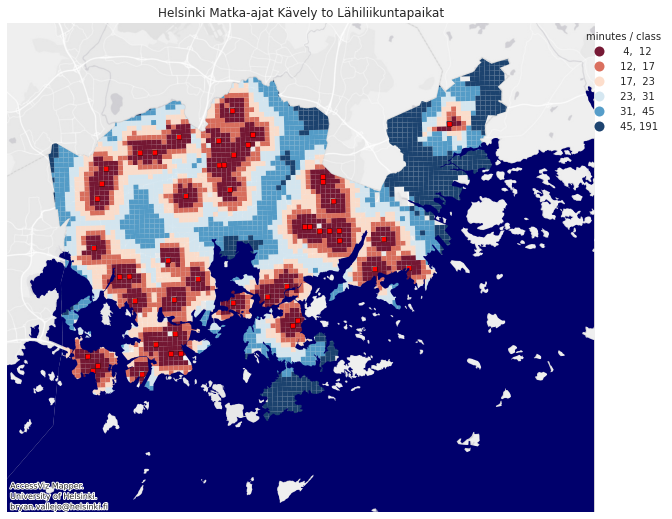

In [9]:
# --------------------------------------------------------------------------------------------

# adding a button widget to download as shp or gpkg. Tooltip is an action which run after click on the button.
txt_button = widgets.Button(description='Yhdistä', 
                            disabled=False, 
                            button_style='primary', 
                            tooltip='Click me', 
                            icon='download')

# --------------------------------------------------------------------------------------------

# output variable is used to display in rendering the selected variable
save_out = widgets.Output()
            
# adding the click event to the button. To add event you do it as a function
txt_button.on_click(save_df_button_clicked)


# ------ TO DISPLAY -------

header = HTML("<p>Yhdistä kaikki YKR ruutu filepathit.</p>  <p><i>Tallentuu pandas dataframeina</i></p>: <p><i> ETA: 6-10 mins</i></p>", layout=Layout(height='auto'))
header.style.text_align='center'

display(header)
display(txt_button)
display(save_out)

## ***3. Visualisointi ja shapefile lataaminen***
________________________
Edellinen shapefile ei ole vielä QGISiin valmiiksi vietäväksi. Seuraavana valitset haluaamasi liikuntatavan millä pääset editoimaan QGIS:issä. 
Choose the desired Tranport Mode, the Classification Scheme, the Color Map, Transparency (alpha), Number of Classes. Then, visualize/download the Map of Travel Times of Helsinki. 

In [10]:
import contextily as ctx
import mapclassify

In [11]:
## FUNCTIONS


# Lataa tiedoston shapefilena
def save_df(save_button):

    global gdf_new

    many = gdf_new

    with map_out:
        clear_output()

    # Sort values in the dataframe by the selected travel mode
    many = many.sort_values(by=selected_t_mode(t_mode_button), ascending=True)
    # Keep the shortest time for duplicate travel time locations
    many = many.drop_duplicates(subset='YKR_ID', keep="first")

    # Simplify the dataframe to only the necessary columns
    many = many[['YKR_ID','from_id','to_id', selected_t_mode(t_mode_button), 'geometry']]

    # defines URL to save the SHP
    shp_url = os.path.join(user_url.value, 'matka-ajat_{}_{}'.format(selected_t_mode(t_mode_button), file_name.value) + '.shp')

    # Report to user that file is saving
    with save_out:
        print('Saving... {}/{}')

    # saving selected YKR ID as SHP file with Travel Times
    many.to_file(shp_url)

    # Report to user where file is saved 
    with save_out:
        print('Saved in: {}\n'.format(shp_url))



# Pelkkä visualisointi ilman kartta lataamista
def vis_many(map_button):


    plt.style.use('seaborn-dark')

    many = gdf_new

    with map_out:
        clear_output()

    # Sort values in the dataframe by the selected travel mode
    many = many.sort_values(by=selected_t_mode(t_mode_button), ascending=True)
    # Keep the shortest time for duplicate travel time locations
    many = many.drop_duplicates(subset='YKR_ID', keep="first")

    assert many['YKR_ID'].is_unique
    with map_out:
        # clear_output()
        print('Mapping...')


    # reading the many and projecting to Mercator (because of basemap)
    many = many.to_crs(3857)


    # reading and projecting the sea
    sea_map = read_sea()
    sea_map = sea_map.to_crs(3857)

    # PLOTTING
    # create base ax
    fig, ax = plt.subplots(figsize=[13, 9])

    # plot map many
    many.plot(ax=ax, column=selected_t_mode(t_mode_button),
                scheme=selected_scheme(class_button),
                k=selected_nclasses(classes_button), 
                cmap=selected_cmap(color_button),
                alpha=selected_alpha(alpha_button),
                legend_kwds={"fmt": "{:.0f}"},
                edgecolor='None',
                linewidth=0,
                legend=True)

    # plot sea
    sea_map.plot(ax=ax, facecolor='#00006c')

    # limits in Mercator
    ax.set_xlim(2760000, 2820000)
    ax.set_ylim(8420000, 8470000)

    for i in many['to_id'].unique():
        k = i.astype(str)
        indiv = many.loc[many['YKR_ID'] == k]
        indiv.plot(ax=ax, facecolor='red', edgecolor='black', linewidth=0.4)

    
    # Turn off tick labels
    ax.set_yticklabels([]);
    ax.set_xticklabels([]);

    # legend anchor
    ax.get_legend().set_bbox_to_anchor((1.13, 1))

    # NAMES

    # title
    ax.title.set_text('Helsinki Matka-ajat {} to {}' \
                        .format(name_of_mode(all_modes, selected_t_mode(t_mode_button)),
                                file_name.value))

    # legend title
    ax.get_legend().set_title('minutes / class')

    # adding basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas, attribution='AccessViz Mapper.\nUniversity of Helsinki.\nbryan.vallejo@helsinki.fi')

    # display
    with map_out:
        plt.show()



# Säästä kartta näkymät png filena
def many_as_png(save_png_button):
    '''
    Def which saves the visualized maps as PNG at the local downloads folder
    ------------------------------------------------------------------------
    :param
    - save_png_button <Widget Button>

    :return
    - Save automatic the Map files as PNG in the local downloads folder
    '''
    plt.style.use('seaborn-dark')

    many = gdf_new

    with map_out:
        clear_output()

    # Sort values in the dataframe by the selected travel mode
    many = many.sort_values(by=selected_t_mode(t_mode_button), ascending=True)
    # Keep the shortest time for duplicate travel time locations
    many = many.drop_duplicates(subset='YKR_ID', keep="first")

    assert many['YKR_ID'].is_unique
    with map_out:
        # clear_output()
        print("Mapping...")

    # reading the many and projecting to Mercator (because of basemap)
    many = many.to_crs(3857)

    # reading and projecting the sea
    sea_map = read_sea()
    sea_map = sea_map.to_crs(3857)

    # PLOTTING

    # create base ax
    fig, ax = plt.subplots(figsize=[13, 9])

    # plot map many
    many.plot(ax=ax, column=selected_t_mode(t_mode_button),
                scheme=selected_scheme(class_button),
                k=selected_nclasses(classes_button),
                cmap=selected_cmap(color_button),
                alpha=selected_alpha(alpha_button),
                legend_kwds={"fmt": "{:.0f}"},
                edgecolor='None',
                linewidth=0,
                legend=True)

    # plot cell to analyze
    for i in many['to_id'].unique():
        k = i.astype(str)
        indiv = many.loc[many['YKR_ID'] == k]
        indiv.plot(ax=ax, facecolor='red', edgecolor='black', linewidth=0.4)

    # plot sea
    sea_map.plot(ax=ax, facecolor='#00006c')

   # limits in Mercator
    ax.set_xlim(2760000, 2820000)
    ax.set_ylim(8420000, 8470000)

    # limits in WGS84
    # ax.set_xlim(24.46, 25.28)
    # ax.set_ylim(60.095, 60.41)

    # Turn off tick labels
    ax.set_yticklabels([]);
    ax.set_xticklabels([]);

    # legend
    ax.get_legend().set_bbox_to_anchor((1.13, 1))


    # title
    ax.title.set_text('Helsinki Matka-ajat {} to {}' \
                        .format(name_of_mode(all_modes, selected_t_mode(t_mode_button)),
                                file_name.value))

    # legend title

    ax.get_legend().set_title('minutes / class')

    # add basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas, attribution='AccessViz Mapper.\nUniversity of Helsinki.\nbryan.vallejo@helsinki.fi')

    # define a name of png file
    name_map = os.path.join("accessviz-mapper/png/", 'Accessibility_{}_{}.png' \
                            .format(name_of_mode(all_modes, selected_t_mode(t_mode_button)),
                                    file_name.value))

    # saving...
    plt.savefig(name_map, dpi=300)

    with map_out:
        print('Map saved in: {}\n'.format(name_map))


In [12]:
# -----------------------------------------------------------------------------
#                                   FUNCTIONS
# -----------------------------------------------------------------------------

def read_sea():
    '''
    Def which gives back a sea layer from local data folder in respository
    ----------------------------------------------------------------------
    :returns
    - sea <GeoDataFrame>
    '''

    # defines sea path url  and reading
    sea_path = os.path.join(home_folder, 'data/sea.shp')
    sea = gpd.read_file(sea_path)

    return sea

def name_of_mode(all_modes, function_botton):
    '''
    Def which gives back the name of the Transport Mode to be mapped, based ond the user selection
    ----------------------------------------------------------------------------------------------
    :param
    - all_modes <list of tuples>
    all_modes is defined in the notebook with the name of the Transport Mode which is shown in the
    dropdown menu

    - function_button <Function>
    this function should give back the selected Transport Mode for the user. The one specified at the
    dropdown menu widget

    :return
    - name_mode <str> name of the selected Transport Mode to be used in the map layout
    '''
    # iterating over all modes

    
    for file in all_modes:
        if function_botton == file[1]:

            # name which is going to be used at the maps
            name_mode = file[0]
    return name_mode

def selected_t_mode(t_mode_button):
    '''
    Def which gives back the selected Transport Mode at the Dropdown menu Widget
    ----------------------------------------------------------------------------
    :param
    - t_mode_button <Widget>

    :return
    - t_mode_button.value <str> selected from dropdown menu
    '''
    return t_mode_button.value

def selected_scheme(class_button):
    '''
    Def which gives back the selected Classification Scheme
    -------------------------------------------------------
    :param
    - class_button <Widget>

    :return
    - class_button.value <str> selected from dropdown menu
    '''
    return class_button.value

def selected_cmap(color_button):
    '''
    Def which gives back the selected Color Map
    -------------------------------------------------------
    :param
    - color_button <Widget>

    :return
    - color_button.value <str> selected from dropdown menu
    '''
    return color_button.value

def selected_alpha(alpha_button):
    '''
    Def which gives back the selected Transparency of the layer
    -------------------------------------------------------
    :param
    - alpha_button <Widget>

    :return
    - alpha_button.value <str> selected from dropdown menu
    '''
    return alpha_button.value

def selected_nclasses(classes_button):
    '''
    Def which gives back the selected Number of Classes
    -------------------------------------------------------
    :param
    - classes_button <Widget>

    :return
    - classes_button.value <str> selected from dropdown menu
    '''
    return classes_button.value


In [ ]:
# tuples with Transportation Modes and given names
t_modes = [('Kävely','walk_t'), 
           ('Pyöräily: hidas', 'bike_s_t'),
           ('Pyöräily: nopea','bike_f_t'),
           ('Julkinen liikenne: ruhka-aika (sis. odotusaika kotona)', 'pt_r_tt'),
           ('Julkinen liikenne: ruhka-aika','pt_r_t'),
           ('Julkinen liikenne: puolipäivä (sis. odotusaika kotona)','pt_m_tt'),
           ('Julkinen liikenne: puolipäivä','pt_m_t'),
           ('Auto: ruhka-aika','car_r_t'),
           ('Auto: puolipäivä','car_m_t'),
           ('Auto: nopeus rajoitukset huomioden','car_sl_t')]

all_modes = [('Kävely','walk_t'),
            ('Pyöräily: hidas', 'bike_s_t'),
            ('Pyöräily: nopea','bike_f_t'),
             ('Julkinen liikenne: ruhka-aika (sis. odotusaika kotona)', 'pt_r_tt'),
             ('Julkinen liikenne: ruhka-aika','pt_r_t'),
             ('Julkinen liikenne: puolipäivä (sis. odotusaika kotona)','pt_m_tt'),
             ('Julkinen liikenne: puolipäivä','pt_m_t'),
             ('Auto: ruhka-aika (sis. odotusaika kotona)','car_r_t'),
             ('Auto: puolipäivä ','car_m_t'),
             ('Auto: nopeus rajoitukset huomioden','car_sl_t'),
             ('Kävely (metreinä)','walk_d'),
             ('Bike (metreinä)','bike_d'),
             ('Julkinen liikenne: ruhka-aika (metreinä)', 'pt_r_d'),
             ('Public Transport Midday (metreinä)','pt_m_d'),
             ('Car Rush Hour (metreinä)','car_r_d'),
             ('Car Midday (metreinä)','car_m_d')]

class_scheme = [('Equal Intervals','equalinterval'),
                ('Natural Breaks', 'naturalbreaks'), 
                ('Quantiles','quantiles')]

color_map = [('Viridis    #Sequential change','viridis'), 
             ('Yellow - Green - Blue    #Sequential change','YlGnBu'),
             ('Turquoise - Purple    #Sequential change', 'cool'),
             ('Pink - Green    #Diverging change', 'PiYG'),
             ('Red - Yellow - Blue    #Diverging change', 'RdYlBu'),
             ('Red - Yellow - Green    #Diverging change', 'RdYlGn'),
             ('Red - Blue    #Diverging change', 'RdBu')]
            
#----------------------------------------------------------------------------------------------------

# adding a text box so the user can enter the url wanted to saved the joined files
user_url = widgets.Text(value = local_folder_default,
                        placeholder='Enter URL', 
                        description='Local folder:', 
                        disabled=False, 
                        continuous_update=True)

# Varmista että anatamasi nimi on käytettävänä kartan otsikkona  
file_name = widgets.Text(value='',
                        placeholder='Anna nimi',
                        description='Tiedoston nimi:',
                        layout = {'width':'max-content'},
                        disabled=False)

# adding a button widget to map downloaded files. Tooltip is an action which run after click on the button.
map_button = widgets.Button(description='Kartoita', 
                            disabled=False, 
                            button_style='success', 
                            tooltip='Click me', 
                            icon='map')

# adding the combobox widget. Combobox means that you can type and select the correct one.
t_mode_button = widgets.Dropdown(placeholder='Valitse kuljetustmuoto', 
                                 options=t_modes, description='Mode:',
                                 value = 'pt_r_t',
                                 ensure_option=True, 
                                 disabled=False)

class_button = widgets.Dropdown(placeholder='Valitse luokittelu', 
                                 options=class_scheme, description='Scheme:',
                                 value = 'naturalbreaks',
                                 ensure_option=True, 
                                 disabled=False)

color_button = widgets.Dropdown(placeholder='Valitse värikartta', 
                                 options = color_map, description='Cmap:',
                                 value = 'PiYG',
                                 ensure_option=True, 
                                 disabled=False)

alpha_button = widgets.FloatSlider(value=0.9,
                                   min=0,
                                   max=1,
                                   step=0.1,
                                   description='Opasiteetti:',
                                   disabled=False,
                                   continuous_update=False,
                                   orientation='horizontal',
                                   readout=True,
                                   readout_format='.1f')

classes_button = widgets.IntSlider(value=11,
                                   min=2,
                                   max=20,
                                   step=1,
                                   description='N Luokkaa:',
                                   disabled=False,
                                   continuous_update=False,
                                   orientation='horizontal',
                                   readout=True,
                                   readout_format='d')

save_png_button = widgets.Button(description='Lataa kartta PNG', 
                            disabled=False, 
                            button_style='primary', 
                            tooltip='Click me', 
                            icon='download')

save_button = widgets.Button(description='Lataa SHP', 
                            disabled=False, 
                            button_style='primary', 
                            tooltip='Click me', 
                            icon='download')
# ------------------------------------------------------------------------------------

# output variable is used to display in rendering the map
map_out = widgets.Output()

# adding the click event to the button. To add event you do it as a function
map_button.on_click(vis_many)
save_png_button.on_click(many_as_png)
save_button.on_click(save_df)

# ------ TO DISPLAY -------

display(t_mode_button)
display(class_button)
display(color_button)
display(alpha_button)
display(classes_button)

display(user_url)
print("Varmista että antamasi nimi on käytettävissä kartan otsikkona")
display(file_name)
display(map_button)
display(save_png_button)
display(save_button)

display(map_out)

## ***4. Väestön Lisääminen *** 

Yhdistä uusi shapefile väestöruutuun 

In [19]:
pop_grid = gpd.GeoDataFrame()

def vaesto_button_clicked(v):

    '''
    Lisää väestötiedot valittuun palvelupiste geodataframeiin
    
    '''
    
    # Retrieve the filepaths of the grid_ids again using the function defined in part 1
    filepaths = create_ykr_files_list(grid_ids)
    # Retrieve the YKR grid for only Helsinki
    ykr = GetCroppedYKR()
    # Call the global variable of table that was defined when selecting the service 
    global table

    # Yhdistää tekstitiedostojen matka-ajat ykr-ruudukkoon kunkin palvelupisteen osalta.
    grid = MergeTable(filepaths, ykr)

    print("Ruudukon solujen määrä", len(grid))


    # Määrittelee datan puuttuvat arvot (-1) ja poistaa rivit, joille ei ole matka-aikoja
    grid = RemoveNoData(grid)

    print("Ruudukon solujen määrä kun nodata poistettu", len(grid))

    # Laskee lyhimmät matka-ajat kävelyn ja julkisen liikenteen osalta kustakin ruudukon solusta
    # palvelupisteen YKR-ruutuun. Laskee lisäksi, kuinka monta palvelupistettä jää annetun ajan
    # mukaisen saavutettavuusvyöhykkeen sisään. Oletuksena 20min.
    grid = ShortestTravelTime(filepaths, grid, time_given.value)

    # Hakee lähimmän palvelupisteen nimen
    grid = ClosestServiceName(table, grid)

    # keep the naming idea, add a widget for users to input their own name!
    global pop_grid
    pop_grid = JoinPopulation(grid, naming_opt.value)

    return pop_grid



In [20]:

def MergeTable(filepaths, grid):

    """ Yhdistää tekstitiedostojen matka-ajat ykr-ruudukkoon kunkin kohdepisteen (palvelupisteen) osalta.
    Parametrit: 
    - filepaths:lista matka-aikamatriisin tekstitiedostojen tiedostopolkuja kullekin kohdepistettä vastaalle ykr-ruudulle. 
    Lista saatiin FileFinder -funktiosta
    - ykr: Helsingin alueelle leikattu ykr-ruudukko. Ruudukko saatiin funktiolla "GetCroppedYkr"
    
    
    """

    # iteroidaan matka-aika matriisin tekstitiedostojen tiedostopolut. 
    for i, fp in enumerate(filepaths):

        #luetaan tekstitiedosto csv-muodossa ja valitaan halutut kolumnit 
        #(matka aika julkisilla ruuhka-aikaan sekä matka-aika kävellen)
        data = pd.read_csv(fp, sep=";", usecols=["from_id", "pt_r_t", "walk_t", "bike_s_t"])
    
        #hae tiedostopolusta ykr id
        cell_ID = fp.split("_")[-1][:-4]
    
        #vaihdetaan kolmunien nimet yksilöllisiksi lisäämällä ykr-id matka-aikatietoihin
        new_names = {"from_id": "YKR_ID", "pt_r_t": "pt_" + cell_ID ,"walk_t": "w_" + 
                     cell_ID, "bike_s_t": "b_" + cell_ID}
        data= data.rename(columns=new_names)
        
        # yhdistetään data ykr-ruudukkoon (tässä kohtaa matka-ajoista tulee paikkatietoa)   
        grid = grid.merge(data, on="YKR_ID")
        
    
    return grid


def RemoveNoData(grid):
    """ Määrittelee datan puuttuvat arvot (-1) ja poistaa rivit, 
    joilla matka-aika kolumnien osalta ei ole voitu ollenkaan laskea matka-aikoja"""
    
    n = len(grid.columns)
    matka_aika_kolumnit = grid.columns[5:n]
    
    grid = grid.replace(to_replace=-1, value=np.nan)
    grid = grid.dropna(axis=0, how='all', thresh=None, subset=matka_aika_kolumnit, inplace=False)
    
    return grid


def ShortestTravelTime(filepaths, grid, time):
    """ Laskee lyhimmän matkustusajan kävelyn ja julkisen liikenteen osalta kutakin palvelupistettä vastaavasta 
    YKR-ruudusta jokaiseen ruudukon soluun. Laskee lisäksi, kuinka monta palvelupistettä jää annetun ajan mukaisen 
    saavutettavuusvyöhykkeen sisään. Funktion parametrit:
    - filepaths: lista tiedostopoluista
    - grid: ruudukko, johon on laskettu matka-ajat kustakin palvelusta jokaiseen ruudukon soluun
    - time: matkustusaika minuutteina, tämän mukaan lasketaan saavutettavuusvyöhykkeellä olevien palvelupisteiden määrä. 
    Oletus 20min.
    """
    
    
    # luodaan uudet tyhjät kolumnit matka-ajoille ja lähimmille palveluille
    grid["min_pt"] = None
    grid["min_walk"] = None
    grid["min_bike"] = None
    grid["min_t"] = None
    grid["closest_pt"] = None
    grid["closest_w"] = None


    # jos kohdepisteitä on monta, laske lyhin matka-aika lähimmälle palvelupisteelle
    if(len(filepaths)>1):
        
        # Asetetaan arvo 999 niille ruuduille, joista ei ole mahdollista laskea lyhintä matka-aikaa 
        grid = grid.replace(to_replace=np.nan, value=999)

        # Valitse matka-aikakolumnit matkustustyypeittäin ja laske näistä kolumneista minimiarvot.       
        ptrt_cols = [col for col in grid if col.startswith("pt_")]
        grid["min_pt"] = grid[ptrt_cols].apply(min, axis=1)

        # Hae lisäksi lähimmän palvelupisteen ykr-koodi.
        grid["closest_pt"] = grid.loc[:, ptrt_cols].idxmin(axis=1).str.slice(start=3)

        #  Toistetaan sama kullekin matkustustyypille erikseen. 

        walk_cols = [col for col in grid if col.startswith("w_")]
        grid["min_walk"] = grid[walk_cols].apply(min, axis=1)

        grid["closest_w"] = grid.loc[:, walk_cols].idxmin(axis=1).str.slice(start=3)
        
        bike_cols = [col for col in grid if col.startswith("b_")]
        grid["min_bike"] = grid[bike_cols].apply(min, axis=1)
        
        # Laske lyhin matka-aika kävellen tai julkisilla kulkien

        grid["min_t"] = grid[['min_walk', 'min_pt']].apply(min, axis=1)
        
    

    # Laske palvelujen määrä annetun ajanmääreen sisällä

    grid['pt_count']=(grid[ptrt_cols] <= time).sum(1)
    grid['walk_count'] = (grid[walk_cols] <= time).sum(1)
    
    
    grid = grid[['YKR_ID', 'geometry', 'min_t', 'min_pt', 'min_walk', 'min_bike', 
    'closest_pt', 'closest_w', 'pt_count', 'walk_count']]

    return grid


def ClosestServiceName(table, grid):
    """ Hakee lähimmän palvelupisteen nimen palvelupistettä vastaavan ykr-koodin mukaan. Funktion parametrit: 
    - table: taulukko, jossa palvelupisteen nimi ja sijaintia vastaava YKR id. Saatiin funktiosta
    ServiceYkrTable()
    - grid: päivitetty ruudukko, johon laskettu lyhimmät matkustusajat, saatu funktiosta ShortestTravelTime()
    """

    # luodaan "sanakirja" jolla yhdistetään ykr-ruudun koodi ja ykr-ruudussa oleva(t) palvelupiste(et)

    table = table[['YKR_ID', 'name']]
    table = table.set_index('YKR_ID')
    dictionary = table.to_dict()
    
    # Asetetaan arvo 999 niille ruuduille, joista ei ole mahdollista laskea lyhintä matka-aikaa 
    grid['closest_pt'] = grid['closest_pt'].replace(to_replace=np.nan, value=999)
    grid['closest_w'] = grid['closest_w'].replace(to_replace=np.nan, value=999)

    # Luodaan tyhjä kolumni julkisilla nopeiten saavutettavaa palvelua varten
    grid['closest_service_pt']=None

    # Haetaan palvelun nimi aiemmin luodun sanakirjan avulla
    for i, row in grid.iterrows():
        if row['closest_pt'] != 999:
            ykr_id = int(row['closest_pt'])
            service = dictionary['name'][ykr_id]
            grid.at[i, 'closest_service_pt'] = service

    # Toistetaan sama kävellen saavutettaville palveluille
    grid['closest_service_w']=None

    for i, row in grid.iterrows():
        if row['closest_w'] != 999:
            ykr_id = int(row['closest_w'])
            service = dictionary['name'][ykr_id]
            grid.at[i, 'closest_service_w'] = service
            
    # Muuta 999 arvot takaisin muotoon NAN
    grid = grid.replace(to_replace=999, value=np.nan)
            
   # grid = grid[['YKR_ID', 'geometry', 'min_t', 'min_pt', 'min_walk', 'min_bike', 'closest_service_pt', 
   #'closest_service_w', 'pt_count', 'walk_count']]
    
    
    return grid


def JoinPopulation(grid, palvelun_nimi):
    """ Yhdistää väestötiedot matka-aikaruudukkoon
    """

    # lue väestöaineisto ja tallenna muuttujaan 'vaki'
    fp = 'data/ika_grid-copy.gpkg'
    vaki = gpd.read_file(fp)
    
    # Hakee wfs rajapinnalta Helsingin kuntarajat ja esikäsittelee datan
    hel = GetHkiBorders()

    # rajaa väestöruutuaineistosta Helsingin alue 
    vaki = gpd.overlay(vaki, hel, how='intersection')
    
    # Varmista, että koordinaattijärjestelmät ovat aineistoissa yhtenevät
    assert grid.crs == vaki.crs, 'Koordinaattijärjestelmät eivät ole yhtenevät!'
    
    # Yhdistä väestötiedot ja saavutettavuusruudukko
    pop_grid = gpd.sjoin(vaki, grid, how="inner", op='within')
    
    #if saavutettavuusluokka == None:
    #    saavutettavuusluokka = 'kaikki_palvelut'
    
    fp = 'valmiit_saavutettavuusruudukot/saavutettavuus_' + palvelun_nimi + '_'
    if not os.path.exists("./valmiit_saavutettavuusruudukot"):
        os.makedirs("./valmiit_saavutettavuusruudukot")
    pop_grid.to_file(fp)
    
    return fp 



# JoinPopulation funktion sisäiset funktiot alkaa #


def GetHkiBorders():
    """ Hakee wfs rajapinnalta pk-seudun kuntien rajat, vaihtaa koordinaattijärjestelmän EPSG:3067 ja 
    palauttaa Helsingin kuntarajat.
    
    """
    url = 'https://kartta.hel.fi/ws/geoserver/avoindata/wfs'
    r = requests.get(url, params = dict(service='WFS', version='2.0.0', request= 'GetFeature', 
    typeName='Seutukartta_aluejako_kuntarajat', outputFormat='json'))

    rajat = gpd.GeoDataFrame.from_features(geojson.loads(r.content))
    
    # Määrittele koordinaattijärjestelmä (EPSG:3879) ja uudelleenprojisoi (EPSG: 3067)
    rajat.crs = CRS.from_epsg(3879)
    rajat = rajat.to_crs(CRS.from_epsg(3067))

    # valitse kuntarajoista Helsingin kuntarajat
    hel = rajat[rajat['nimi']=='Helsinki']
    
    return hel
    


In [21]:

# Käyttäjä päättää tiedoston nimen 
naming_opt = widgets.Text(value='',
                        placeholder='Anna nimi',
                        description='Tiedoston nimi:',
                        layout = {'width':'max-content'},
                        disabled=False)


# Käyttäjä päättää aika saavutettavuusvyöhykkeelle
time_given = widgets.IntSlider(
    value=20,
    min=5,
    max=30,
    step=5,
    description='Tämän mukaan lasketaan saavutettavuusvyöhykkeellä olevien palvelupisteiden määrä. Oletus 20 min',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# adding a button widget to map downloaded files. Tooltip is an action which run after click on the button.
v = widgets.Button(description='Laske lyhyimmät matka-ajat', 
                            disabled=False, 
                            button_style='success', 
                            tooltip='Click me', 
                            icon='map')



# ------------------------------------------------------------------------------------


# adding the click event to the button. To add event you do it as a function
v.on_click(vaesto_button_clicked)

# ------ TO DISPLAY -------

display(naming_opt)
display(time_given)
display(v)

Text(value='', description='Tiedoston nimi:', layout=Layout(width='max-content'), placeholder='Anna nimi')

IntSlider(value=20, continuous_update=False, description='Tämän mukaan lasketaan saavutettavuusvyöhykkeellä ol…

Button(button_style='success', description='Laske lyhyimmät matka-ajat', icon='map', style=ButtonStyle(), tool…

Ruudukon solujen määrä 3826
Ruudukon solujen määrä kun nodata poistettu 3826


<ipython-input-20-f131ea3501a5>:180: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  pop_grid.to_file(fp)


In [22]:
# Taulukot ja väestöanalyysit

def Saavutettavuusvyohyke(pop_grid, column, ikaluokka='IKAKAIKKI', time=20):
    
    """ Laskee kuinka paljon valitun ikäluokan ihmisiä asuu valitun matkustusajan päässä lähimmästä palvelusta.
    Tulostaa tähän liittyviä lukuja ja palauttaa ruudukon, jossa vain määritellyn saavutettavuusalueen ruudut ja niissä
    asuvat henkilöt.
    
    Parametrit:
    - pop_grid : yhdistetty matka-aika ja väestötiedot sisältävä ruudukko
    - column : matka-aikaruudukon kolumni, jossa lyhin matka aika lähimpään palvelupisteeseen matkustusmuodosta riippuen. 
    Valitse joko 'min_walk' (kävely) tai 'min_bike' (pyöräily)
    - ikaluokka : ika-ruudukon kolumni, jossa väestömäärät tietylle ikäluokalle. Oletuksena koko väestö
    - time : saavutettavuusvyöhykkelle määriteltävä maksimimatka-aika. Oletuksena 20min
    
    """    
    
    # Valitsee palvelujen matka-aikatäisyydet luokittelevasta ruudukosta ne ruudut (rivit), joissa 
    # matkustusaika lähimpään kirjastoon on annetun ajanmäärän sisällä
    
    pop_influence_area = pop_grid[pop_grid[column]<=time]
    
    # Laskentoja taulukkoon
    # Väestöä saavutettavuusvyöhykkeen sisällä
    print('Väestöä kolumnin', column, 'mukaisella', time, 'min saavutettavuusvyöhykkeellä ', pop_influence_area[ikaluokka].sum())
    # Saavutettavuusvyöhykkeellä asuvan väestön suhde koko väestöön
    print(time, 'min saavutettavuusvyöhykkeellä asuvan väestön suhde koko väestöön ', 
    pop_influence_area[ikaluokka].sum()/pop_grid[ikaluokka].sum())
    print('Koko ikäluokan väestö ', pop_grid[ikaluokka].sum())
    
    return pop_influence_area


# Taulukko 1. Ikäluokan väestön määrä vaikutusalueella (kuinka monelle kyseinen palvelu on lähin palvelu)

def ServicePressure(pop_grid, service_name, column='closest_service_w', ikaluokka='IKAKAIKKI'):
    """ 
    Tuottaa taulukon, josta ilmenee kullekin palvelulle sen väestön määrä, jolle palvelu on lähin.
    """
    pop_grid = pop_grid.copy()
    pop_grid = pop_grid.dropna(axis=0, how='any', thresh=None, inplace=False)
    
    # ryhmitä lähimmän palvelun mukaan
    closest_services = pop_grid.groupby(column)

        # laske kullekin palvelulle, kuinka monelle henkilölle se on lähin palvelupiste valitun matkustusmuodon mukaan

    service_pressure = pd.DataFrame()
        #columns = ['IKAKAIKKI']

    for key, service in closest_services:
        #print('service')
        people = service[[ikaluokka]].sum()
        people[column] = key
        people['pisin_matka_vaikutusalueella'] = service['min_t'].max()
        service_pressure = service_pressure.append(people, ignore_index=True)


    service_pressure = service_pressure.sort_values(by=ikaluokka, ascending=False)
    
    uudet_nimet = {'IKAKAIKKI' : 'koko_vaesto', 'closest_service_w' : 'lahin_palvelu_kavellen', 'closest_service_pt' : 'lahin_palvelu_julkisilla'}
    service_pressure = service_pressure.rename(columns=uudet_nimet)
    service_pressure.to_excel('accessviz-mapper/taulukot/kayttopaine_' + service_name + '.xlsx')
    
    print("Palvelujen potentiaalinen käyttöpaine (kuinka monelle kyseinen palvelupiste on lähin palvelupiste) ja pisin matkustusaika tällä vaikutusalueella: "  + service_name + " " + tunniste)

    return service_pressure


# Taulukko 2. Väestön määrä saavutettavuusvyöhykkeillä

def TravelTimeGroups(pop_grid, column, ikaluokka, ikaluokan_nimi, service_name):
    
    pop_grid=pop_grid.copy()
    classified_column = column + '_class'
    pop_grid[classified_column]=None

    for i, row in pop_grid.iterrows():
        if row[column] < 15:
            pop_grid.at[i, classified_column] = '0-15 min'
        elif row[column] < 30:
            pop_grid.at[i, classified_column] = '15-30 min'
        else:
            pop_grid.at[i, classified_column] = '30+ min'
    koko_vaesto = pop_grid['IKAKAIKKI'].sum()
    ikaluokan_vaesto = pop_grid[ikaluokka].sum()
    pop_grid['% koko väestosta'] = pop_grid['IKAKAIKKI'] / koko_vaesto *100
    pop_grid['% ikäluokasta'] = pop_grid[ikaluokka] / ikaluokan_vaesto *100

    pop_grid = pop_grid[[classified_column, 'IKAKAIKKI', '% koko väestosta', ikaluokka, '% ikäluokasta', 'geometry']]
    dissolved = pop_grid.dissolve(by=classified_column, aggfunc='sum')
    dissolved = dissolved.rename(columns={'IKAKAIKKI' : 'väestö yhteensä', ikaluokka : ikaluokan_nimi, 'min_walk_class' : 'matka-aika kävellen', 'min_pt_class' : 'matka-aika julkisilla'})
    #dissolved = dissolved[[classified_column, 'IKAKAIKKI', '% koko väestosta', ikaluokka, '% ikäluokasta']]
    dissolved.reset_index(inplace=True)
    
    dissolved.to_excel('taulukot/vaesto_saavutettavuusvyohykkeella_' + service_name + "_" + ikaluokka + '.xlsx')
    
    print("Lähimmän palvelun saavutettavuus laskettu: " + service_name)
    
    return dissolved

In [23]:
def the_button(k):

    pop_fluence = Saavutettavuusvyohyke(pop_grid, k_tapa_button.value, ika_button.value, aika.value)

    ServicePressure(pop_grid, nimi.value, column='closest_service_w', ikaluokka = ika_button.value)


    return print("Osittain valmis")


In [26]:
# tuples with Transportation Modes and given names
kuljetus_tavat = [('Kävely','min_walk'), 
           ('Pyöräily', 'min_bike'),
           ('Julkiset','min_pt')]

# tuples with possible age groups to choose from 
ika_luokat = [('Kaikki','IKAKAIKKI'), ('0-4','IKA0_4'), ('5-9','IKA5_9'),('10-14','IKA10_14'),
('15-19','IKA15_19'), ('20-24','IKA20_24'), ('25-29','IKA25_29'), ('30-34','IKA30_34'), ('35-39','IKA35_39'),
('40-44','IKA40_44'), ('45-49','IKA45-49'), ('50-54','IKA50_54'), ('55-59','IKA55_59'), ('60-64','IKA60_64'),
('65-69','IKA65_69'), ('70-74','IKA70_74'), ('75-79','IKA75_79'), ('80-84','IKA80_84'), ('Yli 85','IKA85YLI')]

# Dropdown menu for choosing transportation
k_tapa_button = widgets.Dropdown(placeholder='Valitse kuljetustmuoto', 
                                 options=kuljetus_tavat, description='Mode:',
                                 value = 'min_walk',
                                 ensure_option=True, 
                                 disabled=False)

# Dropdown menu for choosing age group
ika_button = widgets.Dropdown(placeholder='Valitse ikäluokka', 
                                 options=ika_luokat, description='Ikä:',
                                 value = 'IKAKAIKKI',
                                 ensure_option=True, 
                                 disabled=False)

# Käyttäjä päättää aika saavutettavuusvyöhykkeelle
aika = widgets.IntSlider(
    value=20,
    min=5,
    max=30,
    step=5,
    description='Maksimimatka-aika. Oletuksena 20min',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Käyttäjä päättää tiedoston nimen 
nimi = widgets.Text(value='',
                        placeholder='Anna nimi',
                        description='Tiedoston nimi:',
                        layout = {'width':'max-content'},
                        disabled=False)

# adding a button widget to run the functions. Tooltip is an action which run after click on the button.
k = widgets.Button(description='Laske lyhyimmät matka-ajat', 
                            disabled=False, 
                            button_style='success', 
                            tooltip='Click me', 
                            icon='map')

# ------------------------------------------------------------------------------------


# adding the click event to the button. To add event you do it as a function
k.on_click(the_button)

# ------ TO DISPLAY -------

display(k_tapa_button)
display(ika_button)
display(aika)
display(nimi)
display(k)

Dropdown(description='Mode:', options=(('Kävely', 'min_walk'), ('Pyöräily', 'min_bike'), ('Julkiset', 'min_pt'…

Dropdown(description='Ikä:', options=(('Kaikki', 'IKAKAIKKI'), ('0-4', 'IKA0_4'), ('5-9', 'IKA5_9'), ('10-14',…

IntSlider(value=20, continuous_update=False, description='Maksimimatka-aika. Oletuksena 20min', max=30, min=5,…

Text(value='', description='Tiedoston nimi:', layout=Layout(width='max-content'), placeholder='Anna nimi')

Button(button_style='success', description='Laske lyhyimmät matka-ajat', icon='map', style=ButtonStyle(), tool…

TypeError: string indices must be integers

## ***4. Comparing Travel Times and Distances - Tool***
________________________
Select the Transport Modes you want to compare. Then, visualize/download the Map Comparison of Travel Times.

In [ ]:
# -----------------------------------------------------------------------------
#                                   FUNCTIONS
# -----------------------------------------------------------------------------

def selected_st_mode(st_mode_button):
    '''
    Def which gives back the selected First Transport Mode for Comparison
    -----------------------------------------------------------
    :param
    - st_mode_button <Widget button>

    :return
    - st_mode_button.value <str>
    first selected transportation mode
    '''
    return st_mode_button.value

def selected_nd_mode(nd_mode_button):
    '''
    Def which gives back the selected Second Transport Mode for Comparison
    -----------------------------------------------------------
    :param
    - nd_mode_button <Widget button>

    :return
    - nd_mode_button.value <str>
    first selectede transportation mode
    '''
    return nd_mode_button.value


def comparison_modes_list():
    '''
    Def which gives back the pair of Transport Modes
    ------------------------------------------------
    The condition is that it evaluates that only can be paired Time - Time, or Distance - Distance

    :return
    - selected_modes <list> with two correct selected Transport Modes
    '''

    # define first and second selected mode
    st = selected_st_mode(st_mode_button)
    nd = selected_nd_mode(nd_mode_button)

    selected_modes = []

    # conditional to select pairs. Time with time, and distance with distance
    if st[-1] == nd[-1]:

        # appending if they pair up
        selected_modes.append(st)
        selected_modes.append(nd)

        with comp_out:
            clear_output()
            print('Transportation Modes selected are correct!')
    else:
        with comp_out:
            clear_output()
            print('You only can compare Time-Time or Distance-Distance =D')

    return selected_modes


def map_comparison_modes(map_comp_button):
    '''
    Def which gives back map visualization of the selected transport modes to compare Travel Times
    ----------------------------------------------------------------------------------------------

    :param
    - map_comp_button <Widget Button> for on click event

    :return
    - map visualization in display
    '''

    with comp_out:
        clear_output()

    # call the list with the selected modes
    selected_modes = comparison_modes_list()

    # conditional that must be selected at least 2 modes
    if len(selected_modes) != 0:
        plt.style.use('seaborn-dark')

        # list of files in the local folder
        files_list = get_map_list()

        # number of maps to plot
        n_maps = [n for n in range(len(files_list))]

        # iterates over files to map
        for map_file, n in zip(files_list, n_maps):

            with comp_out:
                # clear_output()
                print('Mapping comparison... {}/{}'.format(n + 1, len(files_list)))

            # reading the data and projecting to Mercator (because of basemap)
            data = gpd.read_file(map_file)
            data = data.to_crs(3857)

            # selecting codes for naming column
            st_code = selected_modes[0].split('_')
            nd_code = selected_modes[1].split('_')

            # creating a new column for calculate comparison
            column_name = '{}_vs_{}'.format(st_code[0], nd_code[0])

            data[column_name] = data[selected_modes[0]] - data[selected_modes[1]]

            # reading and projecting the grid but only the cell the travel times are based
            to_ykr_grid_cell = to_ykr_grid(map_file)
            to_ykr_grid_cell = to_ykr_grid_cell.to_crs(3857)

            # reading and projecting the sea
            sea_map = read_sea()
            sea_map = sea_map.to_crs(3857)

            # PLOTTING

            # create base ax
            fig, ax = plt.subplots(figsize=[13, 9])

            # plot map data
            data.plot(ax=ax, column=column_name,
                      scheme=selected_scheme(class_button),
                      k=selected_nclasses(classes_button),
                      cmap=selected_cmap(color_button),
                      legend_kwds={"fmt": "{:.0f}"},
                      alpha=selected_alpha(alpha_button),
                      edgecolor='None',
                      linewidth=0,
                      legend=True)

            # plot cell to analyze
            to_ykr_grid_cell.plot(ax=ax, facecolor='red', edgecolor='black', linewidth=0.4)

            # plot sea
            sea_map.plot(ax=ax, facecolor='#00006c')

            # limits in Mercator
            ax.set_xlim(2720000, 2820000)
            ax.set_ylim(8420000, 8493000)

            # limits in WGS84
            # ax.set_xlim(24.46, 25.28)
            # ax.set_ylim(60.095, 60.41)

            # Turn off tick labels
            ax.set_yticklabels([]);
            ax.set_xticklabels([]);

            # NAMES

            if st_code[-1] == 't' or nd_code[-1]:
                comp_name = 'Times'
            else:
                comp_name = 'Distances'

                # title
            ax.title.set_text('Helsinki Travel {} Comparison *{} vs {}* to {}' \
                              .format(comp_name,
                                      name_of_mode(all_modes, selected_st_mode(st_mode_button)),
                                      name_of_mode(all_modes, selected_nd_mode(nd_mode_button)),
                                      key_list[val_list.index(ykr_grid_code(map_file))]))

            # legend title
            ax.get_legend().set_title('{} {} - {} {}'.format(st_code[0], comp_name[0], nd_code[0], comp_name[0]))

            ax.get_legend().set_bbox_to_anchor((1.13, 1))

            ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas,
                            attribution='AccessViz Mapper.\nUniversity of Helsinki.\nbryan.vallejo@helsinki.fi')

            with comp_out:
                plt.show()


def maps_comp_as_png(save_png_comp_button):
    '''
    Def which saves the comparison maps as PNG
    ------------------------------------------
    :param
    - save_png_com_button <Widget button> with click on event

    :return
    - Automatic it saves PNG files of the visualized maps
    '''

    with comp_out:
        clear_output()

    # call the list with the selected modes
    selected_modes = comparison_modes_list()

    if len(selected_modes) != 0:
        plt.style.use('seaborn-dark')

        # list of files in the local folder
        files_list = get_map_list()

        # number of maps to plot
        n_maps = [n for n in range(len(files_list))]

        # iterates over files to map
        for map_file, n in zip(files_list, n_maps):

            with comp_out:
                # clear_output()
                print('Saving comparison map... {}/{}'.format(n + 1, len(files_list)))

            # reading the data and projecting to Mercator (because of basemap)
            data = gpd.read_file(map_file)
            data = data.to_crs(3857)

            # selecting codes for naming column
            st_code = selected_modes[0].split('_')
            nd_code = selected_modes[1].split('_')

            # creating a new column for calculate comparison
            column_name = '{}_vs_{}'.format(st_code[0], nd_code[0])

            data[column_name] = data[selected_modes[0]] - data[selected_modes[1]]

            # reading and projecting the grid but only the cell the travel times are based
            to_ykr_grid_cell = to_ykr_grid(map_file)
            to_ykr_grid_cell = to_ykr_grid_cell.to_crs(3857)

            # reading and projecting the sea
            sea_map = read_sea()
            sea_map = sea_map.to_crs(3857)

            # PLOTTING

            # create base ax
            fig, ax = plt.subplots(figsize=[13, 9])

            # plot map data
            data.plot(ax=ax, column=column_name,
                      scheme=selected_scheme(class_button),
                      k=selected_nclasses(classes_button),
                      cmap=selected_cmap(color_button),
                      legend_kwds={"fmt": "{:.0f}"},
                      alpha=selected_alpha(alpha_button),
                      edgecolor='None',
                      linewidth=0,
                      legend=True)

            # plot cell to analyze
            to_ykr_grid_cell.plot(ax=ax, facecolor='red', edgecolor='black', linewidth=0.4)

            # plot sea
            sea_map.plot(ax=ax, facecolor='#00006c')

            # limits in Mercator
            ax.set_xlim(2720000, 2820000)
            ax.set_ylim(8420000, 8493000)

            # limits in WGS84
            # ax.set_xlim(24.46, 25.28)
            # ax.set_ylim(60.095, 60.41)

            # Turn off tick labels
            ax.set_yticklabels([]);
            ax.set_xticklabels([]);

            # NAMES

            # conditional to name it in map *title
            if st_code[-1] == 't' or nd_code[-1]:
                comp_name = 'Times'
            else:
                comp_name = 'Distances'

            # title
            ax.title.set_text('Helsinki Travel {} Comparison *{} vs {}* in YKR Grid {}' \
                              .format(comp_name,
                                      name_of_mode(all_modes, selected_st_mode(st_mode_button)),
                                      name_of_mode(all_modes, selected_nd_mode(nd_mode_button)),
                                      key_list[val_list.index(ykr_grid_code(map_file))]))

            # legend title
            ax.get_legend().set_title('{} {} - {} {}'.format(st_code[0], comp_name[0], nd_code[0], comp_name[0]))

            ax.get_legend().set_bbox_to_anchor((1.13, 1))

            ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas,
                            attribution='AccessViz Mapper.\nUniversity of Helsinki.\nbryan.vallejo@helsinki.fi')

            # name comparison map
            name_comp_map = os.path.join(user_url.value, 'Accessibility_YKRID_{}_{}_vs_{}.png' \
                                         .format(key_list[val_list.index(ykr_grid_code(map_file))],
                                                 name_of_mode(all_modes, selected_st_mode(st_mode_button)),
                                                 name_of_mode(all_modes, selected_st_mode(nd_mode_button))))

            # saving map
            plt.savefig(name_comp_map, dpi=300)

            with comp_out:
                print('Map saved in: {}\n'.format(name_comp_map))
                # plt.show()


def save_compmap_shp(shp_comp_button):
    '''
    Def which saves YKR ID with travel time info + comparison column as SHP
    -----------------------------------------------------------------------
    :param
    - shp_comp_button <Widget button>
    :return
    - Automatic saves SHP files of the comparison Travel Times
    '''

    with comp_out:
        clear_output()

    # call the list with the selected modes
    selected_modes = comparison_modes_list()

    if len(selected_modes) != 0:
        # plt.style.use('seaborn-dark')

        # list of files in the local folder
        files_list = get_map_list()

        # number of maps to plot
        n_maps = [n for n in range(len(files_list))]

        # iterates over files to map
        for map_file, n in zip(files_list, n_maps):

            with comp_out:
                # clear_output()
                print('Saving comparison map SHP... {}/{}'.format(n + 1, len(files_list)))

            # reading the data and projecting to Mercator (because of basemap)
            data = gpd.read_file(map_file)
            data = data.to_crs(3857)

            # selecting codes for naming column
            st_code = selected_modes[0].split('_')
            nd_code = selected_modes[1].split('_')

            # creating a new column for calculate comparison
            column_name = '{}_vs_{}'.format(st_code[0], nd_code[0])

            data[column_name] = data[selected_modes[0]] - data[selected_modes[1]]

            # NAMES

            if st_code[-1] == 't' or nd_code[-1]:
                comp_name = 'Times'
            else:
                comp_name = 'Distances'

            # name comparison map
            name_comp_shp = os.path.join(user_url.value, 'travel_{}_comp_to_{}_{}_vs_{}.shp' \
                                         .format(comp_name,
                                                 key_list[val_list.index(ykr_grid_code(map_file))],
                                                 st_code[0],
                                                 nd_code[0]))

            # saving file
            data.to_file(name_comp_shp)

            with comp_out:
                print('SHP saved in: {}\n'.format(name_comp_shp))


def save_compmap_gpkg(gpkg_comp_button):
    '''
    Def which saves YKR ID with travel time info + comparison column as SHP
    -----------------------------------------------------------------------
    :param
    - gpkg_comp_button <Widget button>
    :return
    - Automatic saves SHP files of the comparison Travel Times
    -
    '''

    with comp_out:
        clear_output()

    # call the list with the selected modes
    selected_modes = comparison_modes_list()

    if len(selected_modes) != 0:

        # list of files in the local folder
        files_list = get_map_list()

        # number of maps to plot
        n_maps = [n for n in range(len(files_list))]

        # iterates over files to map
        for map_file, n in zip(files_list, n_maps):

            with comp_out:
                # clear_output()
                print('Saving comparison map GPKG... {}/{}'.format(n + 1, len(files_list)))

            # reading the data and projecting to Mercator (because of basemap)
            data = gpd.read_file(map_file)
            data = data.to_crs(3857)

            # selecting codes for naming column
            st_code = selected_modes[0].split('_')
            nd_code = selected_modes[1].split('_')

            # creating a new column for calculate comparison
            column_name = '{}_vs_{}'.format(st_code[0], nd_code[0])

            data[column_name] = data[selected_modes[0]] - data[selected_modes[1]]

            # NAMES

            # conditional to write the name in title
            if st_code[-1] == 't' or nd_code[-1]:
                comp_name = 'Times'
            else:
                comp_name = 'Distances'

            # name comparison map
            name_comp_gpkg = os.path.join(user_url.value, 'travel_{}_comp_to_{}_{}_vs_{}.gpkg' \
                                          .format(comp_name,
                                                  ykr_grid_code(map_file),
                                                  st_code[0],
                                                  nd_code[0]))

            # saving file
            data.to_file(name_comp_gpkg, driver='GPKG')

            with comp_out:
                print('GPKG saved in: {}\n'.format(name_comp_gpkg))

In [ ]:
def save_com_shp(shp_comp_button):

    # call the list with the selected modes
    selected_modes = comparison_modes_list()

    many = gpd.read_file("accessviz-mapper/downloads/matka-ajat_Lähiliikuntapaikat.shp")

    with map_out:
        # clear_output()
        print("Mapping...")

    # reading the many and projecting to Mercator (because of basemap)
    many = many.to_crs(3857)

    # selecting codes for naming column
    st_code = selected_modes[0].split('_')
    nd_code = selected_modes[1].split('_')

    # creating a new column for calculate comparison
    column_name = '{}_vs_{}'.format(st_code[0], nd_code[0])

    many[column_name] = many[selected_modes[0]] - many[selected_modes[1]]

    many = many.sort_values(by=column_name, ascending=True)
    # Keep the shortest time for duplicate travel time locations
    many = many.drop_duplicates(subset='YKR_ID', keep="first")

    assert many['YKR_ID'].is_unique

    # NAMES

    if st_code[-1] == 't' or nd_code[-1]:
        comp_name = 'Times'
    else:
        comp_name = 'Distances'

    # name comparison map
    name_comp_shp = os.path.join("accessviz-mapper/downloads/", 'travel_{}_comp_to_{}_{}_vs_{}.shp' \
                                    .format(comp_name,
                                            column_name,
                                            st_code[0],
                                            nd_code[0]))

    name_map = os.path.join("accessviz-mapper/downloads/", 'Accessibility_{}_{}.png' \
                            .format(name_of_mode(all_modes, selected_t_mode(t_mode_button)),
                                    "Lähiliikuntapaikat"))

    # saving file
    many.to_file(name_comp_shp)

    with comp_out:
        print('SHP saved in: {}\n'.format(name_comp_shp))


In [ ]:
               
# ------------------------------------------------------------------------------------------------
                                                                                      
# adding widgets of Comparison Travel Times
st_mode_button = widgets.Dropdown(placeholder='Select first transport mode', 
                                 options=all_modes, description='1st Mode:',
                                 value = 'bike_s_t',
                                 ensure_option=True, 
                                 disabled=False)

nd_mode_button = widgets.Dropdown(placeholder='Select second transport mode', 
                                 options=all_modes, description='2nd Mode:',
                                 value = 'car_r_t',
                                 ensure_option=True, 
                                 disabled=False)

map_comp_button = widgets.Button(description='Map comparison', 
                                 disabled=False, 
                                 button_style='success', 
                                 tooltip='Click me', 
                                 icon='map')

save_png_comp_button = widgets.Button(description='Save maps PNG',
                                      disabled=False, 
                                      button_style='primary', 
                                      tooltip='Click me', 
                                      icon='download')

shp_comp_button = widgets.Button(description='Save as SHP',
                                 disabled=False,
                                 button_style='primary',
                                 tooltip='Click me', 
                                 icon='download')

gpkg_comp_button = widgets.Button(description='Save as GPKG', 
                                  disabled=False, 
                                  button_style='primary',
                                  tooltip='Click me', 
                                  icon='download')

# ----------------------------------------------------------------------------------------

comp_out = widgets.Output()
                                           
# adding the click event to the button. To add event you do it as a function
map_comp_button.on_click(map_comparison_modes)
save_png_comp_button.on_click(maps_comp_as_png)

shp_comp_button.on_click(save_com_shp)
gpkg_comp_button.on_click(save_compmap_gpkg)
                                           
# ------------------------
# TO DISPLAY


display(st_mode_button)
display(nd_mode_button)

#display(class_button)
#display(color_button)
#display(alpha_button)
#display(classes_button)


display(map_comp_button)
display(save_png_comp_button)
display(shp_comp_button)
display(gpkg_comp_button)

display(comp_out)

## ***5. Shortest Path - Routing Tool***
________________________
Select the YKR IDs you want to find the Shortest Path(s). You can include few Origins and Destinations. Then, choose the Network Type, Color Map of Shortest Paths(s). Finally, visualize/download the map of Shortest Path(s). Try some YKR IDs in the sample fata like: *Origins:* `5963655`. *Destinations:* `5925860`, `5933038`, `5816105`. 

In [ ]:
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, Polygon, LineString

In [ ]:
# -----------------------------------------------------------------------------
#                                   FUNCTIONS
# -----------------------------------------------------------------------------
def path_origin_button_clicked(add_id_origin):
    '''
    Def used to append and print in display the selected YKR IDs origin for shortest path
    -------------------------------------------------------------------------------
    :param
    - add_id_origin <Widget Button>
    :return
    - display the selected YKR ID for origin of shortest path
    '''

    # conditional to avoid repeated origins and/or destinations
    if select_origin_id.value not in origin_ids and select_origin_id.value not in destin_ids:
        if select_origin_id.value != '':
            origin_ids.append(select_origin_id.value)

            with o_out:
                return print('Origin(s) YKR IDs: {}'.format(origin_ids))


def path_destin_button_clicked(add_id_destin):
    '''
    Def used to append and print in display the selected YKR IDs destination for shortest path
    -------------------------------------------------------------------------------
    :param
    - add_id_destin <Widget Button>
    :return
    - display the selected YKR ID for origin of shortest path
    '''

    # conditional to avoid repeated origins and/or destinations
    if select_destin_id.value not in destin_ids and select_destin_id.value not in origin_ids:
        if select_destin_id.value != '':
            destin_ids.append(select_destin_id.value)

            with d_out:
                return print('Destination(s) YKR IDs: {}'.format(destin_ids))


def origin_button_clear(clear_origin_ids):
    '''
    Def used to clear selected YKR IDs
    ----------------------------------
    :param
    - clear_origin_ids <Widget button>
    :return
    - Clear list with selected origins YKR IDs
    '''

    origin_ids.clear()

    with o_out:
        clear_output()
        return print('Origin(s) YKR IDs cleared!: {}\n'.format(origin_ids))


def destin_button_clear(clear_destin_ids):
    '''
    Def used to clear selected YKR IDs
    ----------------------------------
    :param
    - clear_destin_ids <Widget button>
    :return
    - Clear list with selected destinations YKR IDs
    '''

    destin_ids.clear()

    with d_out:
        clear_output()
        return print('Destination(s) YKR IDs cleared!: {}\n'.format(destin_ids))

# ------------------------- NETWORK TYPE SELECTION ---------------------------------------

def selected_path_cmap(color_path_button):
    '''
    Def which gives back the selected Color Map
    -------------------------------------------
    :param
    color_path_button <Widget Button>
    :return
    color_path_button.value <str> Color map of Routes
    '''
    return color_path_button.value

def selected_network_type():
    '''
    Def which gives back the value selected at the Network Type
    ----------------------------------------------------------
    '''
    return select_network_button.value


def OD_list(origin_ids, destin_ids):
    '''
    Def which gives back the YKR Grid centroids with the selected YKR IDs origins and destinations
    ----------------------------------------------------------------------------------------------
    :param
    - origin_ids <list> with selected origins YKR IDs
    - destin_ids <list> with selected destinations YKR IDs
    :return
    - [origin_centroids, destin_centroids] <list> list with 2 elements <lists>.
    first list is centroids of origins, second list is centroids of destinations
    '''

    # creating empty lists
    origin_centroids = []
    destin_centroids = []

    for origin_id in origin_ids:
        # reading the entire YKR Grid
        grid_path_sub = read_grid(grid_path)
        grid_path_sub['YKR_ID'] = grid_path_sub['YKR_ID'].astype(str)

        # subset of grid based of the code of the file
        grid_path_sub = grid_path_sub.loc[grid_path_sub['YKR_ID'] == origin_id]

        # projecting to local epsg to measure distances
        # grid_path_sub = grid_path_sub[['geometry']].to_crs(epsg = 32635)

        # define index for locating geometry
        geom_index = grid_path_sub.index[0]

        # centroid
        centroid_geom = grid_path_sub.at[geom_index, 'geometry'].centroid

        # List of Origins:
        centroidxy = (centroid_geom.x, centroid_geom.y)

        # appending to a list
        origin_centroids.append(centroidxy)

    for destin_id in destin_ids:
        # reading the entire YKR Grid
        grid_path_sub = read_grid(grid_path)
        grid_path_sub['YKR_ID'] = grid_path_sub['YKR_ID'].astype(str)

        # subset of grid based of the code of the file
        grid_path_sub = grid_path_sub.loc[grid_path_sub['YKR_ID'] == destin_id]

        # projecting to local epsg to measure distances
        # grid_path_sub = grid_path_sub[['geometry']].to_crs(epsg = 32635)

        # define index for locating geometry
        geom_index = grid_path_sub.index[0]

        # centroid
        centroid_geom = grid_path_sub.at[geom_index, 'geometry'].centroid

        # List of Origins
        centroidxy = (centroid_geom.x, centroid_geom.y)

        # appending to a list
        destin_centroids.append(centroidxy)

    return [origin_centroids, destin_centroids]


def graph_extent_bbox(origin_centroids_list, destin_centroids_list):
    '''
    Def which gives back the bounding box of the origins and destinations
    ---------------------------------------------------------------------
    :param
    - origin_centroids_list <list>
    - destin_centroids_list <list>

    :return
    graph_extent <Geometry Object Polygon>
    Extension of the Origins and Destinations
    '''

    # all points in list
    all_OD_coors = origin_centroids_list + destin_centroids_list

    # all points dataframe
    all_points = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs=CRS.from_epsg(4326))  # 32635
    all_points['geometry'] = [Point(pair_coors) for pair_coors in all_OD_coors]

    # defyning a bounding box
    total_bounds = all_points['geometry'].total_bounds

    xmin = total_bounds[0]
    ymin = total_bounds[1]
    xmax = total_bounds[2]
    ymax = total_bounds[3]

    bbox_coords = Polygon([[xmin, ymax], [xmin, ymin], [xmax, ymin], [xmax, ymax]])

    # adding buffer
    graph_extent = bbox_coords.buffer(0.02)

    return graph_extent


def fetch_graph_network(graph_extent):
    '''
    Def which gives back the Graph file with Network Selected and graph extent
    --------------------------------------------------------------------------

    '''

    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type=selected_network_type())

    # fig, ax = ox.plot_graph(graph)

    # reprojecting the graph
    graph_proj = ox.project_graph(graph)

    # obtaining geodataframes of nodes, edges
    nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

    return graph


def find_shortest_path():
    '''
    Def which gives back a geodataframe(plot) with the Shortest Paths
    -----------------------------------------------------------------
    :return:
    - routes <GeoDataFrame> with shortest paths
    '''

    with path_out:
        print('Starting...')

    # getting the origins and destinations ids
    all_OD = OD_list(origin_ids, destin_ids)
    origins_OD = all_OD[0]
    destins_OD = all_OD[1]

    # getting the bounding box of the network
    graph_bbox = graph_extent_bbox(origins_OD, destins_OD)

    with path_out:
        print('Fetching Network...')

    # getting the graph network in wgs84
    graph = fetch_graph_network(graph_bbox)

    # reprojecting the graph
    graph_proj = ox.project_graph(graph)

    # obtaining geodataframes of nodes, edges

    global nodes_proj
    global edges_proj
    nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

    # Origins create a geodataframe with coordinates and project to the local UTM Zone epsg 32635
    origins_wgs = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs=CRS.from_epsg(4326))
    origins_wgs['geometry'] = [Point(origin_pair) for origin_pair in origins_OD]

    global orig_proj
    orig_proj = origins_wgs.to_crs(epsg=32635)

    # Destins create a geodataframe with coordinates and project to the local UTM Zone epsg 32635
    destins_wgs = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs=CRS.from_epsg(4326))
    destins_wgs['geometry'] = [Point(destin_pair) for destin_pair in destins_OD]

    global dest_proj
    dest_proj = destins_wgs.to_crs(epsg=32635)

    # Store the shortest path routes as LineString geometries in a GeoDataFrame called routes:
    routes = None

    # creating a list of origins and destination switched x and y.
    originsyx = [(point.y, point.x) for point in orig_proj['geometry']]
    destinationsyx = [(point.y, point.x) for point in dest_proj['geometry']]

    with path_out:
        print('Finding nodes...')

    # finding the nearest nodes for origins and destinations, in a list
    orig_node_id = [ox.get_nearest_node(graph_proj, orig_points, method='euclidean') for orig_points in originsyx]
    dest_node_id = [ox.get_nearest_node(graph_proj, dest_points, method='euclidean') for dest_points in destinationsyx]

    # creating routes with impedance length of the route and saving it in geodataframe
    routes = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs=edges_proj.crs)

    # list of routes geometries and osm ids
    routes_geom = []
    routes_osmids = []

    with path_out:
        print('Finding Shortest(s) Path(s)...')

    # iterating over origins and destinations.
    for origin_node in orig_node_id:
        for dest_node in dest_node_id:
            # if origin is the same as destination then no routing
            if origin_node == dest_node:
                skip
            else:
                # create route as graph object
                route = nx.shortest_path(G=graph_proj, source=origin_node, target=dest_node, weight='length')

                # getting the attributes of the route with nodes_proj
                route_nodes = nodes_proj.loc[route]

                # getting the osmid of the route from nodes_proj
                routes_osmid = str(route_nodes.osmid.astype(str).to_list())

                # creating a linestring with geometries
                route_line = LineString(route_nodes.geometry.to_list())

                # appending the linestring to a list to then add it to a gdf
                routes_geom.append(route_line)

                # appending the osmid to a list to then add it to a gdf
                routes_osmids.append(routes_osmid)

    # adding the attributes (lists) to the Geodataframe
    routes['geometry'] = routes_geom
    routes['osmids'] = routes_osmids

    return routes


def map_shortest_path(map_path_button):
    '''
    Def which display maps of the Shortest Path
    -------------------------------------------
    :param
    - map_path_button <Widget Button>
    :return
    - Map of shortest path in Display
    '''

    with path_out:
        clear_output()

    # get the routes
    global routes
    routes = find_shortest_path()

    # creating a new column with distance
    routes['route_dist'] = routes.length

    # PLOTTING

    global fig, ax
    # create base ax
    fig, ax = plt.subplots(figsize=[13, 9])

    # projecting data to display with basemap

    # plot map data
    routes.plot(ax=ax, column='route_dist',
                # scheme = selected_scheme(class_button),
                # k = selected_nclasses(classes_button),
                cmap=selected_path_cmap(color_path_button),
                alpha=0.8,
                # legend_kwds = {"fmt": "{:.1f}"},
                linewidth=3,
                zorder=1,
                legend=True)

    # plotting nodes
    global orig_proj
    orig_proj.plot(ax=ax, facecolor='black', markersize=14, zorder=2)

    global dest_proj
    dest_proj.plot(ax=ax, facecolor='red', markersize=14, zorder=3)

    # global edges_proj
    edges_proj.plot(ax=ax, edgecolor='dimgray', linewidth=0.4,
                    alpha=0.8)

    # Turn off tick labels
    ax.set_yticklabels([]);
    ax.set_xticklabels([]);

    # NAMES

    # title
    ax.title.set_text('Shortest Path in {} (meters)\nOrigin(s) YKR IDs: {}\nDestination(s) YKR IDs: {}' \
                      .format(name_of_mode(network_type, selected_network_type()),
                              origin_ids,
                              destin_ids))
    # white background
    ax.set_facecolor('xkcd:white')

    # set label x as attribution
    ax.set_xlabel('AccessViz Mapper.\nUniversity of Helsinki.\nbryan.vallejo@helsinki.fi')

    with path_out:
        plt.show()


def shp_shortest_path(shp_path_button):
    '''
    Def which display maps of the Shortest Path
    -------------------------------------------
    :param
    - shp_path_button <Widget button>
    :return
    Saves the Routes as SHP at the local folder
    '''

    with path_out:
        clear_output()

    # get the routes
    # routes = find_shortest_path()

    # creating a new column with distance
    routes['route_dist'] = routes.length

    # name routes
    name_route = os.path.join(user_url.value, 'Shortest_Paths_{}_{}_origins_{}_destinations.shp' \
                              .format(name_of_mode(network_type, selected_network_type()),
                                      len(origin_ids),
                                      len(destin_ids)))
    with path_out:
        print('Saving...')

    # saving file
    routes.to_file(name_route)

    with path_out:
        print('Shortest Path(s) saved in: {}\n'.format(name_route))


def png_shortest_path(png_path_button):
    '''
    Def which save maps of the Shortest Path
    ----------------------------------------
    :param
    - png_path_button <Widget button>
    :return
    Saves PNG files of shortest path map
    '''

    with path_out:
        clear_output()

    # get the routes
    global routes
    routes = find_shortest_path()

    # creating a new column with distance
    routes['route_dist'] = routes.length

    # PLOTTING

    # create base ax
    fig, ax = plt.subplots(figsize=[13, 9])

    # plot map data
    routes.plot(ax=ax, column='route_dist',
                # scheme = selected_scheme(class_button),
                # k = selected_nclasses(classes_button),
                cmap=selected_path_cmap(color_path_button),
                alpha=0.8,
                # legend_kwds = {"fmt": "{:.1f}"},
                linewidth=3,
                zorder=1,
                legend=True)

    # plotting nodes
    global orig_proj
    orig_proj.plot(ax=ax, facecolor='black', markersize=12, zorder=2)

    global dest_proj
    dest_proj.plot(ax=ax, facecolor='red', markersize=12, zorder=3)

    # global edges_proj
    edges_proj.plot(ax=ax, edgecolor='dimgray', linewidth=0.4,
                    alpha=0.8)

    # Turn off tick labels
    ax.set_yticklabels([]);
    ax.set_xticklabels([]);

    # NAMES

    # title
    ax.title.set_text('Shortest Path in {} (meters)\nOrigin(s) YKR IDs: {}\nDestination(s) YKR IDs: {}' \
                      .format(name_of_mode(network_type, selected_network_type()),
                              origin_ids,
                              destin_ids))
    # white background
    ax.set_facecolor('xkcd:white')

    # set label x as attribution
    ax.set_xlabel('AccessViz Mapper.\nUniversity of Helsinki.\nbryan.vallejo@helsinki.fi')

    with path_out:
        clear_output()
        print('Saving...')

    # name of map
    name_map_route = os.path.join(user_url.value, 'Shortest_Paths_{}_{}_origins_{}_destinations.png' \
                                  .format(name_of_mode(network_type, selected_network_type()),
                                          len(origin_ids),
                                          len(destin_ids)))

    # saving map
    plt.savefig(name_map_route, dpi=300)

    with path_out:
        print('Map saved in: {}\n'.format(name_map_route))
        # plt.show()

In [ ]:
# creating a list of YKR IDs for shortest path (global variable)
origin_ids = []
destin_ids = []

# -----------------------------------------------------------------------------------------

# adding the combobox widget. Combobox means that you can type and select the correct one.
select_origin_id = widgets.Combobox(placeholder='Type/select the YKR ID', 
                                 options=grid_list, description='OriginID',
                                 ensure_option=True, 
                                 disabled=False)

select_destin_id = widgets.Combobox(placeholder='Type/select the YKR ID', 
                                 options=grid_list, description='DestinationID',
                                 ensure_option=True, 
                                 disabled=False)

# adding the button widget. Click Me Tooltip is an action which run after clicking on the button.
add_id_origin = widgets.Button(description='Add OriginID', 
                   disabled=False, 
                   button_style='info', 
                   tooltip='Click me', 
                   icon='check')

add_id_destin = widgets.Button(description='Add DestinationID', 
                   disabled=False, 
                   button_style='info', 
                   tooltip='Click me', 
                   icon='check')

clear_origin_ids = widgets.Button(description='Clear Origin(s)', 
                   disabled=False, 
                   button_style='danger', 
                   tooltip='Click me', 
                   icon='remove')

clear_destin_ids = widgets.Button(description='Clear Destin(s)', 
                   disabled=False, 
                   button_style='danger', 
                   tooltip='Click me', 
                   icon='remove')

# -----------------------------------------------------------------------------------------

# output variable is used to display in rendering the selected variable
o_out = widgets.Output()
d_out = widgets.Output()
        
# adding the click event to the button. To add event you do it as a function
add_id_origin.on_click(path_origin_button_clicked)

add_id_destin.on_click(path_destin_button_clicked)

clear_origin_ids.on_click(origin_button_clear)

clear_destin_ids.on_click(destin_button_clear)

# ------ TO DISPLAY -------

display(select_origin_id)
display(select_destin_id)

display(add_id_origin)
display(add_id_destin)

display(clear_origin_ids)
display(clear_destin_ids)

display(o_out)
display(d_out)

#### ***Choose Network Type***

In [ ]:
# a list with the network types
# network_type "all_private", "all", "bike", "drive", "drive_service", "walk"
network_type = [('All Networks','all'), 
                ('Bike Paths Network','bike'), 
                ('Road Network','drive'), 
                ('Walk Paths Network', 'walk')]

color_path_map = [('Viridis    #Sequential change','viridis'), 
                 ('Yellow - Green - Blue    #Sequential change','YlGnBu'),
                 ('Turquese - Purple    #Sequential change', 'cool')]

# ---------------------------------------------------------------------------

# adding the widget to get information of Network
select_network_button = widgets.Dropdown(placeholder='Select Path Network', 
                                 options=network_type, description='Path Network',
                                 value = 'drive',
                                 ensure_option=True, 
                                 disabled=False)

map_path_button = widgets.Button(description='Find Shortest Path', 
                                 disabled=False, 
                                 button_style='success', 
                                 tooltip='Click me', 
                                 icon='map')

color_path_button = widgets.Dropdown(placeholder='Select a color map', 
                                     options = color_path_map, description='Route Cmap:',
                                     value = 'cool',
                                     ensure_option=True, 
                                     disabled=False)

shp_path_button = widgets.Button(description='Save Routes SHP',
                                 disabled=False,
                                 button_style='primary',
                                 tooltip='Click me', 
                                 icon='download')
                        
png_path_button = widgets.Button(description='Save Map PNG',
                                 disabled=False,
                                 button_style='primary',
                                 tooltip='Click me', 
                                 icon='download')

# ---------------------------------------------------------------------------

path_out = widgets.Output()

# create event on click
map_path_button.on_click(map_shortest_path)
shp_path_button.on_click(shp_shortest_path)
png_path_button.on_click(png_shortest_path)

# ------ TO DISPLAY -------
display(select_network_button)
display(color_path_button)

display(map_path_button)
display(shp_path_button)
display(png_path_button)


display(path_out)

### ***YKR ID Explorer***
________________________
Here you can explore the YKR IDs of the Travel Time Matrix of Helsinki Region. 

In [ ]:
# -----------------------------------------------------------------------------
#                                   FUNCTIONS
# -----------------------------------------------------------------------------

def grid_codes(feature):
    '''Def which gives back a Style Color
    :param
    - feature <feature> Defined feature already. No need eto specify inside GeoJson Folium
    :return
    <dictionary> with style colors
    '''

    YKR_grid = low_series.get(int(feature['id']), None)

    return {'fillColor': 'black',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0,
            'opacity': 0.4}

In [ ]:
# including an ID for Folium
grid['geoid'] = grid.index.astype(str)

# creating a map instance visualize the grid
m = folium.Map(width=700, height=500, location=[60.25, 24.85], zoom_start=10, control_scale=True)

# setting a series that will be used in Style Function
low_series = grid.set_index('geoid')

# creating a GeoJson of the Grid Features and adding to the map instance
grid_gjson = folium.features.GeoJson(grid, name='YKR_Grid', style_function=grid_codes,
                                     tooltip=folium.features.GeoJsonTooltip(fields=['YKR_ID'],
                                             aliases = ['YKR Identifier'],
                                             labels=True,
                                             sticky=True))
grid_gjson.add_to(m);

In [ ]:
m